# Basic library & settings

In [1]:
# Primary library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# visualization setting
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (15, 8)
sns.set(font_scale=1.2)

# 한글 폰트 경로 설정
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'  # 맥용 기본 한글 폰트
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family='AppleGothic')  # 기본 폰트 설정

# Data Load & Basic information search

In [2]:
df = pd.read_csv("/Users/b._.chan/Documents/DKU_DataScience/Not_Null/data/raw/train.csv")

# Data basic information
print(f"Data size : {df.shape}")
print("\n first 5 rows of data : ")
print(df.head())


Data size : (23587209, 19)

 first 5 rows of data : 
  module(equipment)      timestamp       localtime  operation  voltageR  \
0           14(2호기)  1739918155000  20250218143555          1    216.65   
1          16(호이스트)  1742552385000  20250321031945          1    212.13   
2        11(우측분전반1)  1738245780000  20250130060300          1    219.30   
3          5(좌측분전반)  1740645790000  20250227004310          1    214.15   
4        18(우측분전반2)  1737829500000  20250125102500          1    212.07   

   voltageS  voltageT  voltageRS  voltageST  voltageTR  currentR  currentS  \
0    215.21    216.89     373.99     374.20     375.45     17.76      6.59   
1    216.51    218.88     371.20     377.04     373.26     17.75     12.07   
2    211.36    212.71     372.96     367.24     374.12     27.54     12.88   
3    213.73    210.73     370.54     367.58     367.95     26.78      7.03   
4    215.52    215.66     370.29     373.40     370.41     29.51      8.88   

   currentT  activePower  p

## 전력 예측 시 꼭 참고해야 할 주요 컬럼
- activePower (유효 전력) : 순간적으로 설비가 소비하는 전력량 (kW) 으로, 가장 직접적인 전력 사용량 지표
- accumActiveEnergy (누적 유효 전력량) : 지금까지 누적 소비한 전력량 (kWh) 으로, 하루/주/월 단위 총 사용량 예측 시 중요
- operation (가동 여부) : 설비가 켜져 있는지 여부 (1 = 가동) 으로, 꺼져 있으면 전력 거의 사용하지 않음.
- localtime (시간 정보) : 한국 시간 기준 (String) 으로, 주간/야간, 평일/주말 패턴 분석 가능
- voltageR/S/T, currentR/S/T : 전압 및 전류 값으로, 부하 급변 상황 = 전력 소비 급증 가능성 있음.

In [3]:
# Data type & memory usage check
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23587209 entries, 0 to 23587208
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   module(equipment)     object 
 1   timestamp             int64  
 2   localtime             int64  
 3   operation             int64  
 4   voltageR              float64
 5   voltageS              float64
 6   voltageT              float64
 7   voltageRS             float64
 8   voltageST             float64
 9   voltageTR             float64
 10  currentR              float64
 11  currentS              float64
 12  currentT              float64
 13  activePower           float64
 14  powerFactorR          float64
 15  powerFactorS          float64
 16  powerFactorT          float64
 17  reactivePowerLagging  float64
 18  accumActiveEnergy     int64  
dtypes: float64(14), int64(4), object(1)
memory usage: 3.3+ GB
None


In [4]:
# describe data check
print("\n Data description : ")
print(df.describe())


 Data description : 
          timestamp     localtime   operation      voltageR      voltageS  \
count  2.358721e+07  2.358721e+07  23587209.0  2.358721e+07  2.358721e+07   
mean   1.739519e+12  2.024839e+13         1.0  2.149942e+02  2.149946e+02   
std    3.739740e+09  3.664714e+09         0.0  2.901942e+00  2.902580e+00   
min    1.733040e+12  2.024120e+13         1.0  1.901000e+02  1.901400e+02   
25%    1.736280e+12  2.025011e+13         1.0  2.125000e+02  2.125000e+02   
50%    1.739521e+12  2.025021e+13         1.0  2.150000e+02  2.150000e+02   
75%    1.742757e+12  2.025032e+13         1.0  2.175000e+02  2.175000e+02   
max    1.745996e+12  2.025043e+13         1.0  2.200000e+02  2.200000e+02   

           voltageT     voltageRS     voltageST     voltageTR      currentR  \
count  2.358721e+07  2.358721e+07  2.358721e+07  2.358721e+07  2.358721e+07   
mean   2.149940e+02  3.723703e+02  3.723701e+02  3.723697e+02  1.750025e+01   
std    2.902125e+00  3.572992e+00  3.572323e+00

In [5]:
# missing value check
print("\n Missing value check : ")
print(df.isnull().sum())


 Missing value check : 
module(equipment)       0
timestamp               0
localtime               0
operation               0
voltageR                0
voltageS                0
voltageT                0
voltageRS               0
voltageST               0
voltageTR               0
currentR                0
currentS                0
currentT                0
activePower             0
powerFactorR            0
powerFactorS            0
powerFactorT            0
reactivePowerLagging    0
accumActiveEnergy       0
dtype: int64


# Time data preprocessing

In [6]:
# localtime data type check
print("localtime data sample")
print(df['localtime'].head())


localtime data sample
0    20250218143555
1    20250321031945
2    20250130060300
3    20250227004310
4    20250125102500
Name: localtime, dtype: int64


In [7]:
# timestamp & localtime column type transform
def convert_timestamp(x):
    try:
        # 1. timestamp column type transform
        return pd.to_datetime(str(x), format="%Y%m%d%H%M%S")
    except:
        return pd.NaT


In [8]:
# localtime transform
df['datetime'] = df['localtime'].apply(convert_timestamp)

# transform results check
print("\nconverted datetime column")
print(df['datetime'].head())


converted datetime column
0   2025-02-18 14:35:55
1   2025-03-21 03:19:45
2   2025-01-30 06:03:00
3   2025-02-27 00:43:10
4   2025-01-25 10:25:00
Name: datetime, dtype: datetime64[ns]


In [9]:
# Time feature extraction
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['weekday'] = df['datetime'].dt.weekday
df['week'] = df['datetime'].dt.isocalendar().week

# Time feature check
print("\nTime feature check")
print(df[['datetime', 'year', 'month', 'day', 'hour', 'weekday', 'week']].head())



Time feature check
             datetime  year  month  day  hour  weekday  week
0 2025-02-18 14:35:55  2025      2   18    14        1     8
1 2025-03-21 03:19:45  2025      3   21     3        4    12
2 2025-01-30 06:03:00  2025      1   30     6        3     5
3 2025-02-27 00:43:10  2025      2   27     0        3     9
4 2025-01-25 10:25:00  2025      1   25    10        5     4


In [10]:
# 설비 별 데이터 개수 check
print("설비별 데이터 개수")
equipment_counts = df["module(equipment)"].value_counts()
print(equipment_counts)

설비별 데이터 개수
module(equipment)
12(4호기)       1816301
3(분쇄기(2))     1815173
15(예비건조기)     1815046
2(L-1전등)      1814686
17(6호기)       1814667
1(PM-3)       1814588
11(우측분전반1)    1814487
14(2호기)       1814436
16(호이스트)      1814067
5(좌측분전반)      1813767
4(분쇄기(1))     1813651
18(우측분전반2)    1813239
13(3호기)       1813101
Name: count, dtype: int64


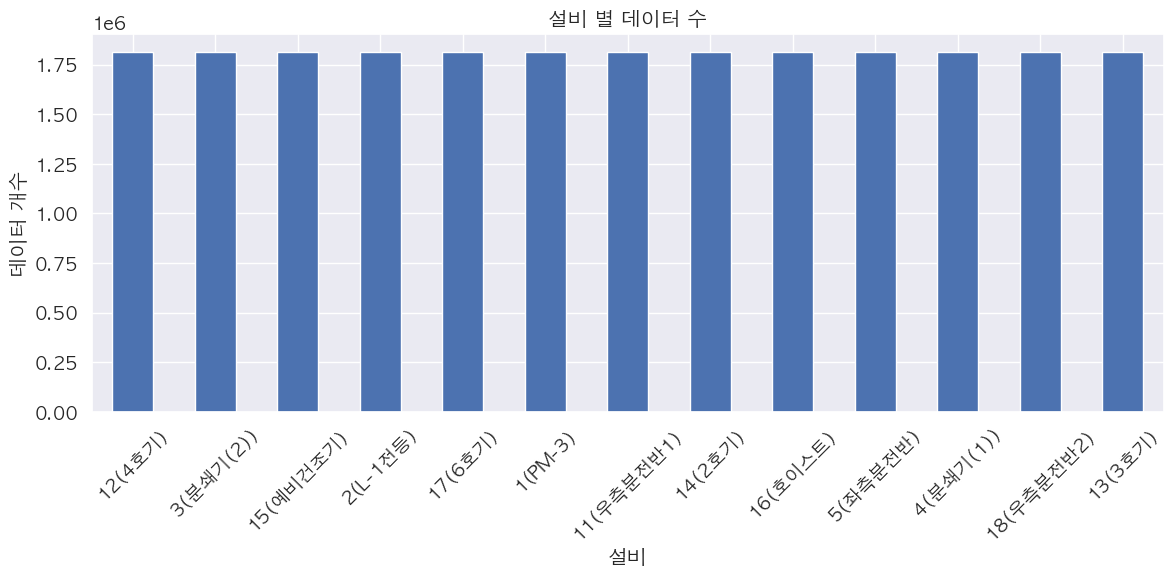

In [11]:
plt.figure(figsize=(12, 6))
equipment_counts.plot(kind="bar")
plt.title("설비 별 데이터 수")
plt.xlabel("설비")
plt.ylabel("데이터 개수")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# operation distribution check
print("\noperation distribution")
operation_counts = df['operation'].value_counts()
print(operation_counts)


operation distribution
operation
1    23587209
Name: count, dtype: int64


-> 모든 설비가 가동되고 있음을 확인 가능,,

In [13]:
power_columns = ["activePower", "reactivePowerLagging", "accumActiveEnergy"]
print("전력 관랸 통계량")
print(df[power_columns].describe())

전력 관랸 통계량
        activePower  reactivePowerLagging  accumActiveEnergy
count  2.358721e+07          2.358721e+07       2.358721e+07
mean   3.009983e+03          6.019165e+02       8.104020e+06
std    7.172040e+02          2.290891e+02       3.344687e+06
min    8.644400e+02          8.944000e+01       1.129013e+06
25%    2.503740e+03          4.231400e+02       5.394751e+06
50%    3.009880e+03          5.739000e+02       8.104245e+06
75%    3.515950e+03          7.553800e+02       1.081312e+07
max    5.219730e+03          1.550630e+03       1.543817e+07


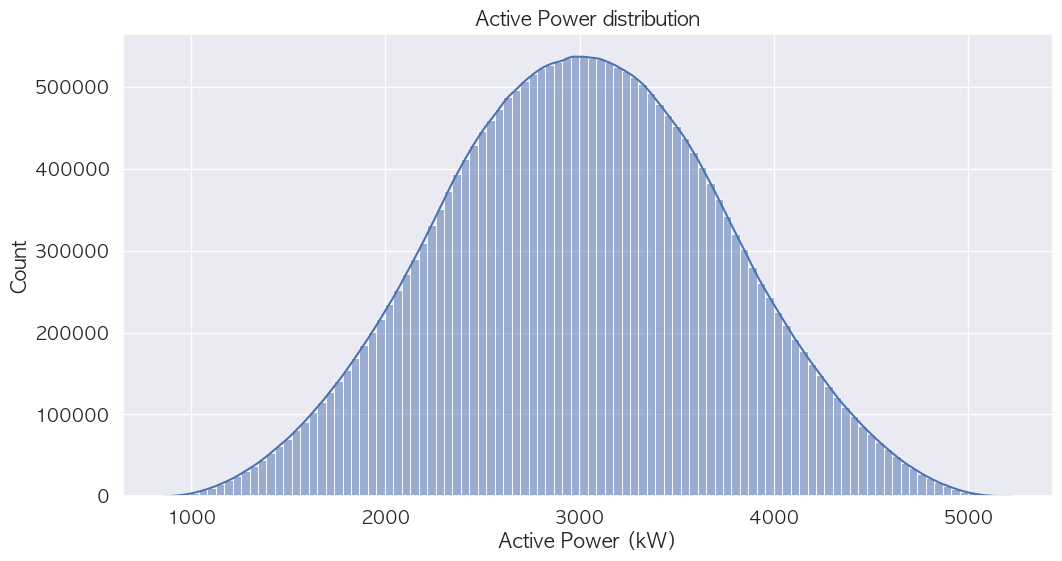

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(df["activePower"], kde=True, bins=100)
plt.title("Active Power distribution")
plt.xlabel("Active Power (kW)")
plt.show()

- 완벽한 normal distribution 을 이루고 있음.
-> why? ,, 흠..

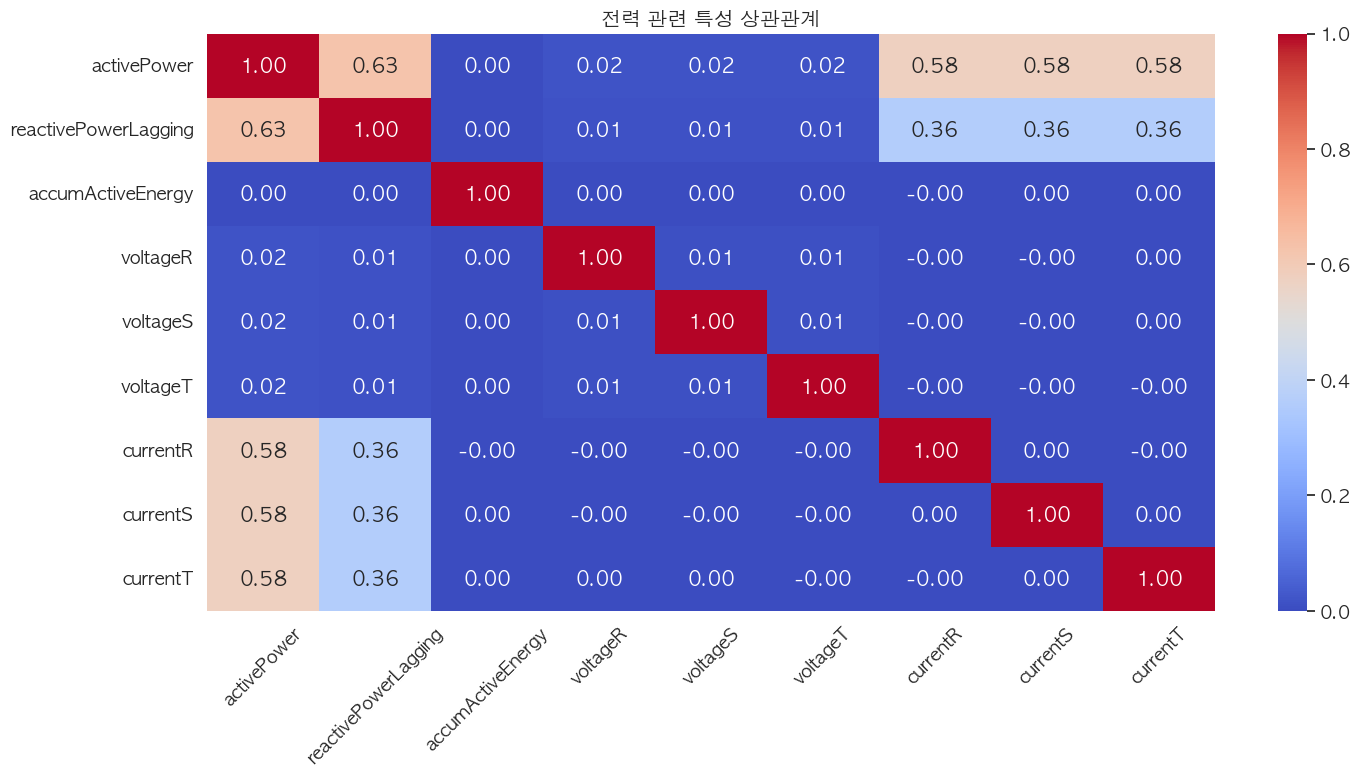

In [15]:
power_corr = df[power_columns + ["voltageR", "voltageS", "voltageT", "currentR", "currentS", "currentT"]].corr()
plt.figure(figsize=(15, 8))
sns.heatmap(power_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("전력 관련 특성 상관관계")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- activePower 와 reactivePowerLagging 양의 상관관계 (0.63) 확인
- activePower 와 currentR/S/T 양의 상관관계 (0.58) 확인


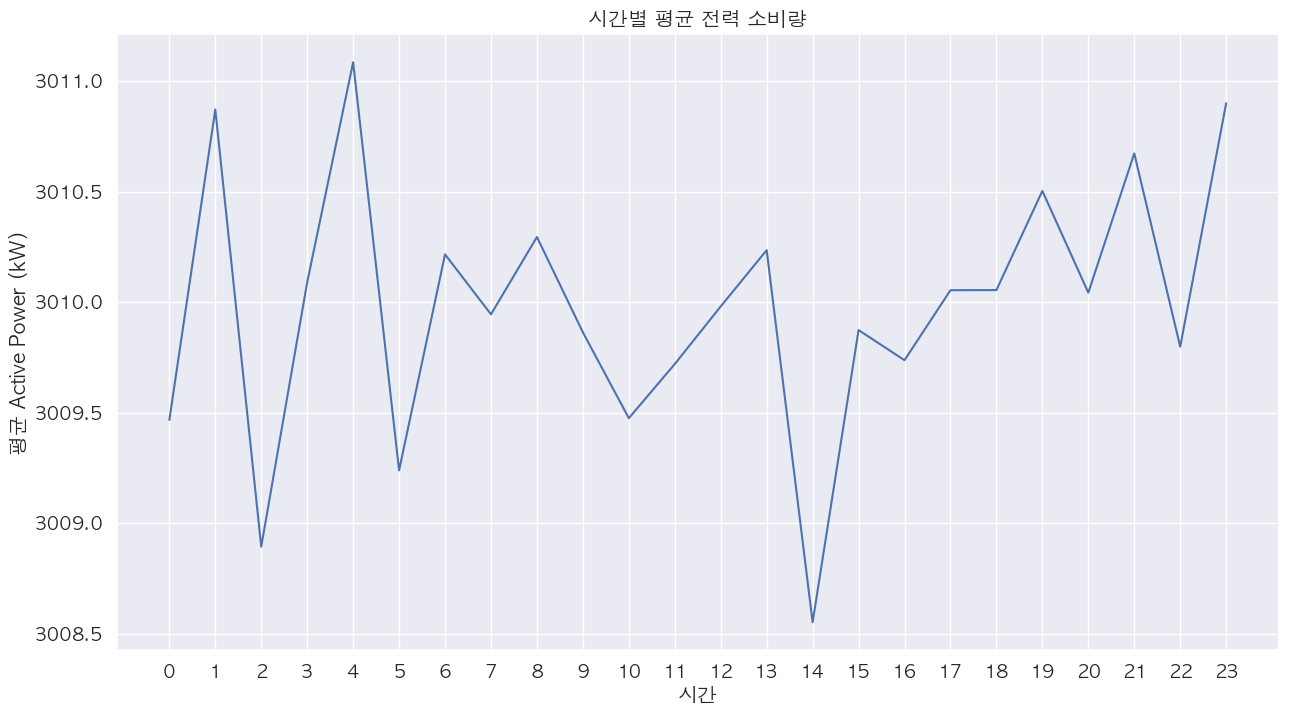

In [16]:
# 시간별 전력 소비량
hourly_power = df.groupby("hour")["activePower"].mean().reset_index()

plt.figure(figsize=(15, 8))
sns.lineplot(x="hour", y="activePower", data=hourly_power, markers="o")
plt.title("시간별 평균 전력 소비량")
plt.xlabel("시간")
plt.ylabel("평균 Active Power (kW)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

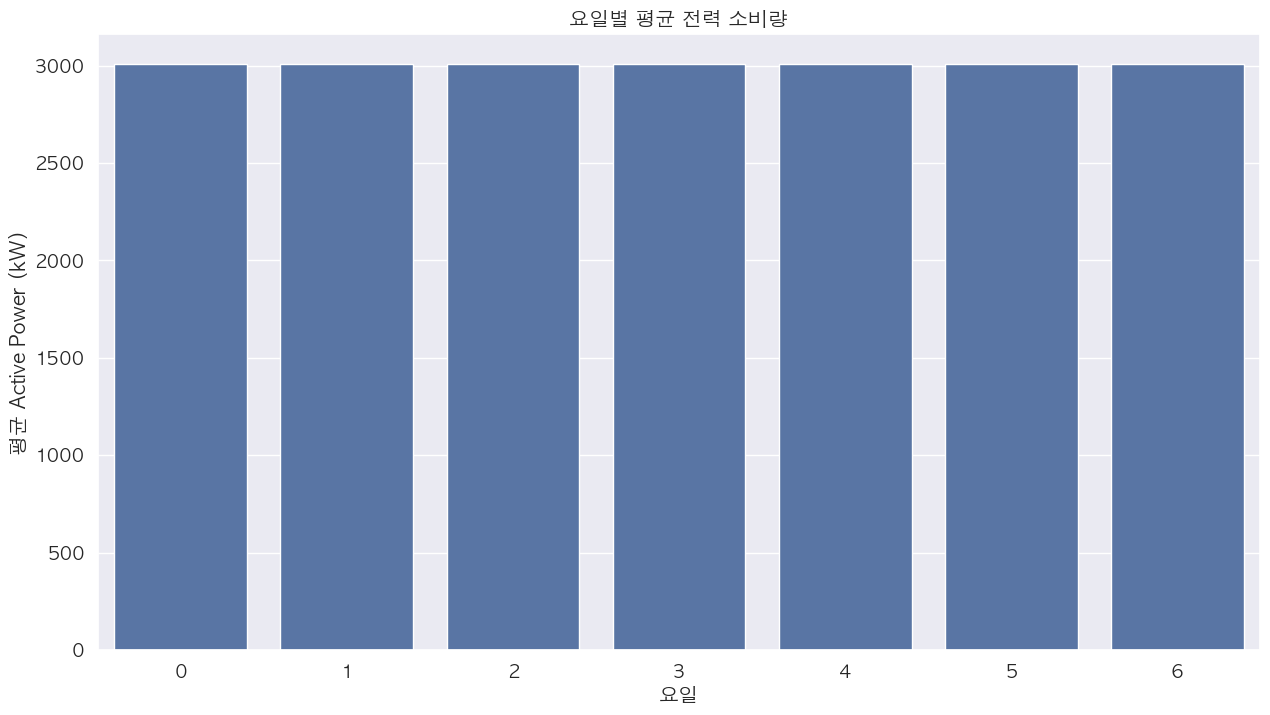

In [17]:
weekday_power = df.groupby("weekday")["activePower"].mean().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(x="weekday", y="activePower", data=weekday_power)
plt.title("요일별 평균 전력 소비량")
plt.xlabel("요일")
plt.ylabel("평균 Active Power (kW)")
plt.grid(True, axis="y")
plt.show()

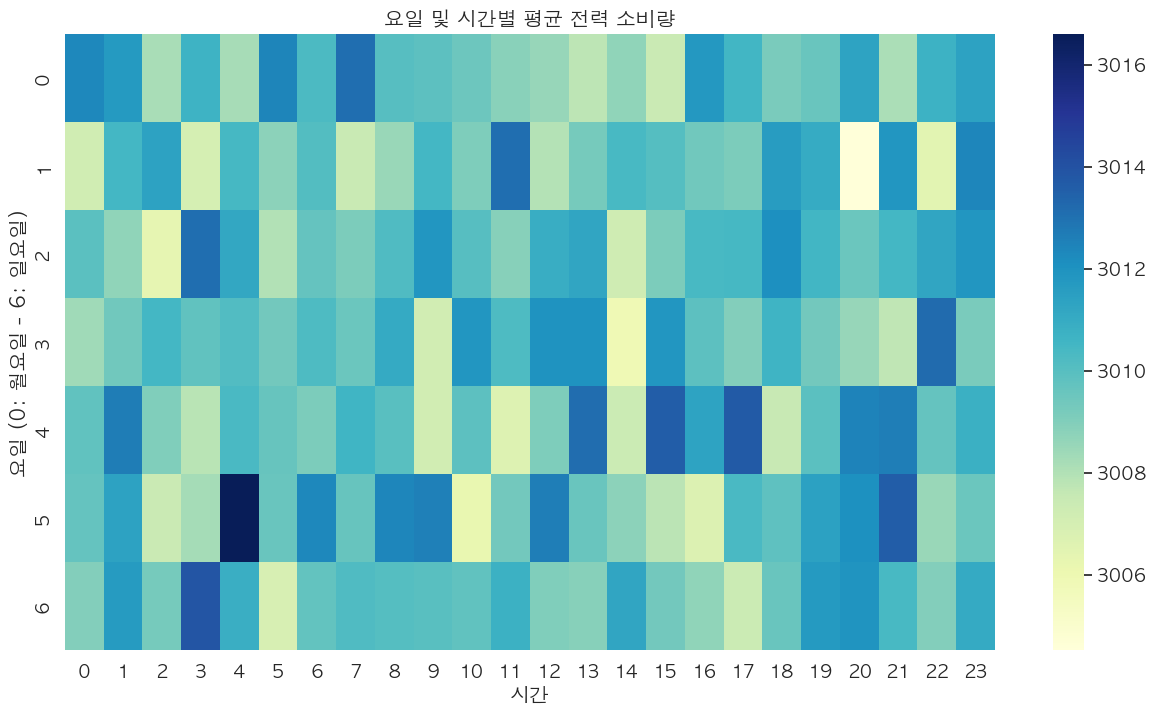

In [18]:
hourly_weekday_power = df.groupby(["weekday", "hour"])["activePower"].mean().reset_index()
hourly_weekday_pivot = hourly_weekday_power.pivot(index="weekday", columns="hour", values="activePower")

plt.figure(figsize=(15, 8))
sns.heatmap(hourly_weekday_pivot, cmap="YlGnBu", annot=False, fmt=".2f")
plt.title("요일 및 시간별 평균 전력 소비량")
plt.xlabel("시간")
plt.ylabel("요일 (0: 월요일 - 6: 일요일)")
plt.show()

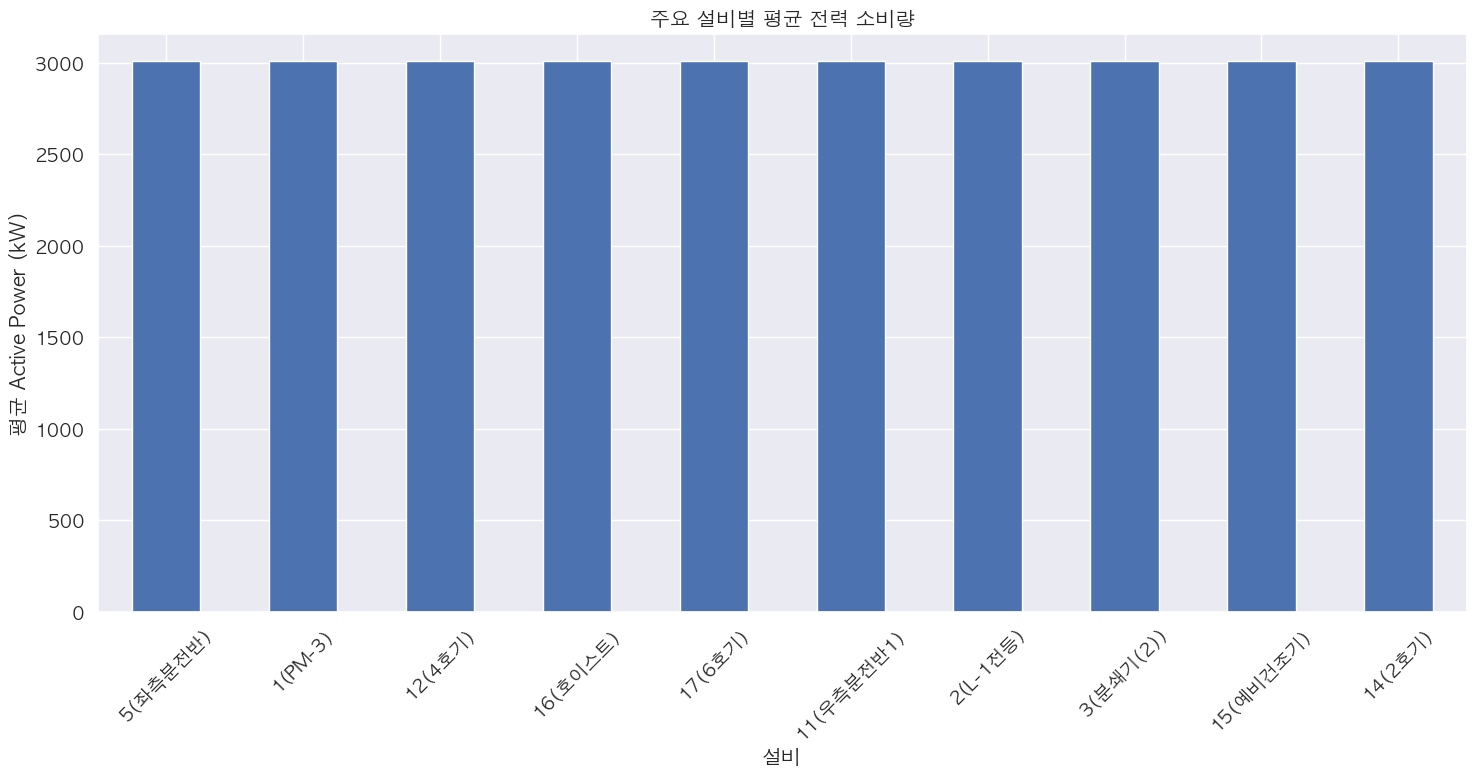

In [19]:
top_equipment = equipment_counts.index[:10]
equipment_power = df[df["module(equipment)"].isin(top_equipment)].groupby("module(equipment)")["activePower"].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 8))
equipment_power.plot(kind="bar")
plt.title("주요 설비별 평균 전력 소비량")
plt.xlabel("설비")
plt.ylabel("평균 Active Power (kW)")
plt.xticks(rotation=45)
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

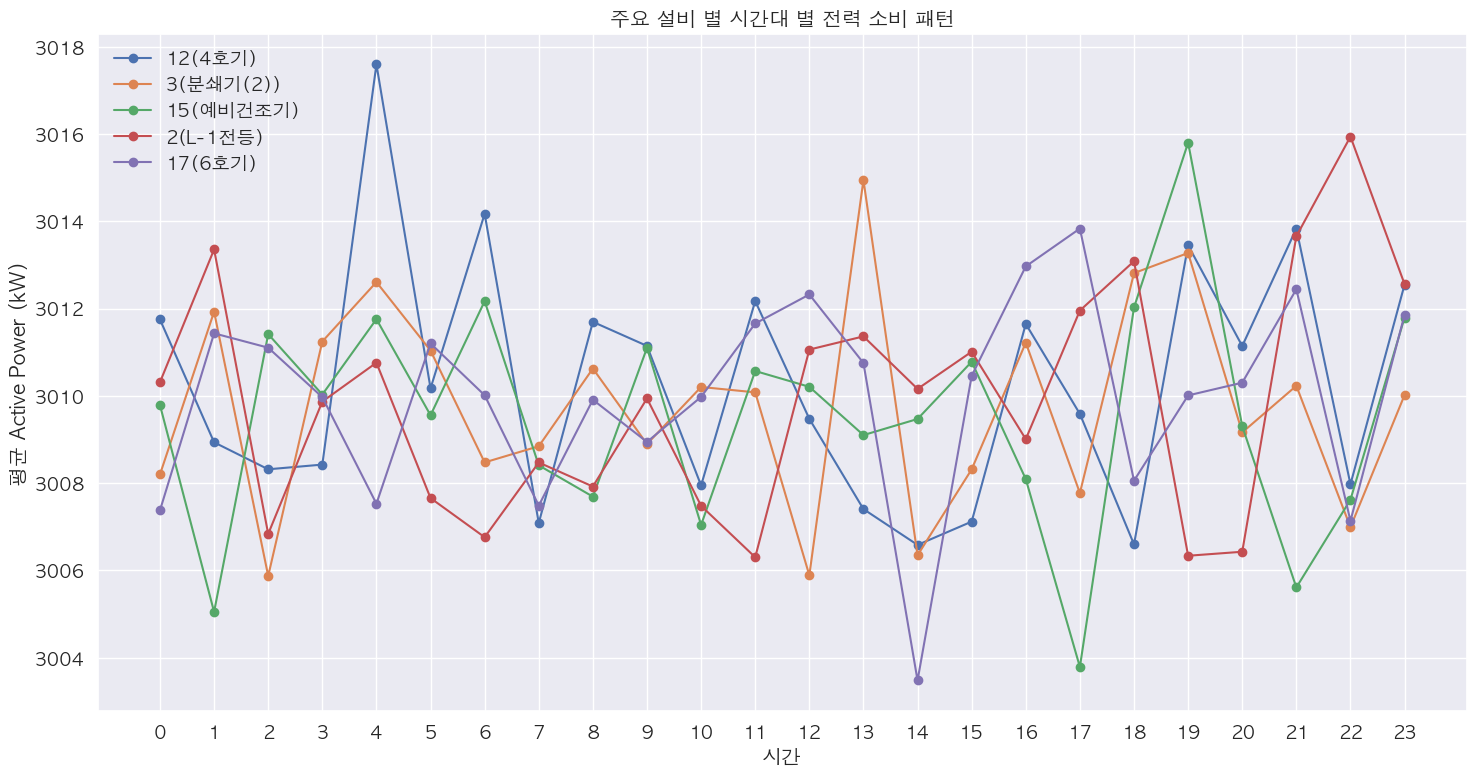

In [22]:
# 시간대별 주요 설비 전력 소비 패턴 확인
plt.figure(figsize=(15, 8))
for equipment in top_equipment[:5]: # 상위 5개
    temp_df = df[df["module(equipment)"] == equipment]
    hourly = temp_df.groupby("hour")["activePower"].mean()
    plt.plot(hourly.index, hourly.values, marker="o", label=equipment)
    
plt.title("주요 설비 별 시간대 별 전력 소비 패턴")
plt.xlabel("시간")
plt.ylabel("평균 Active Power (kW)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

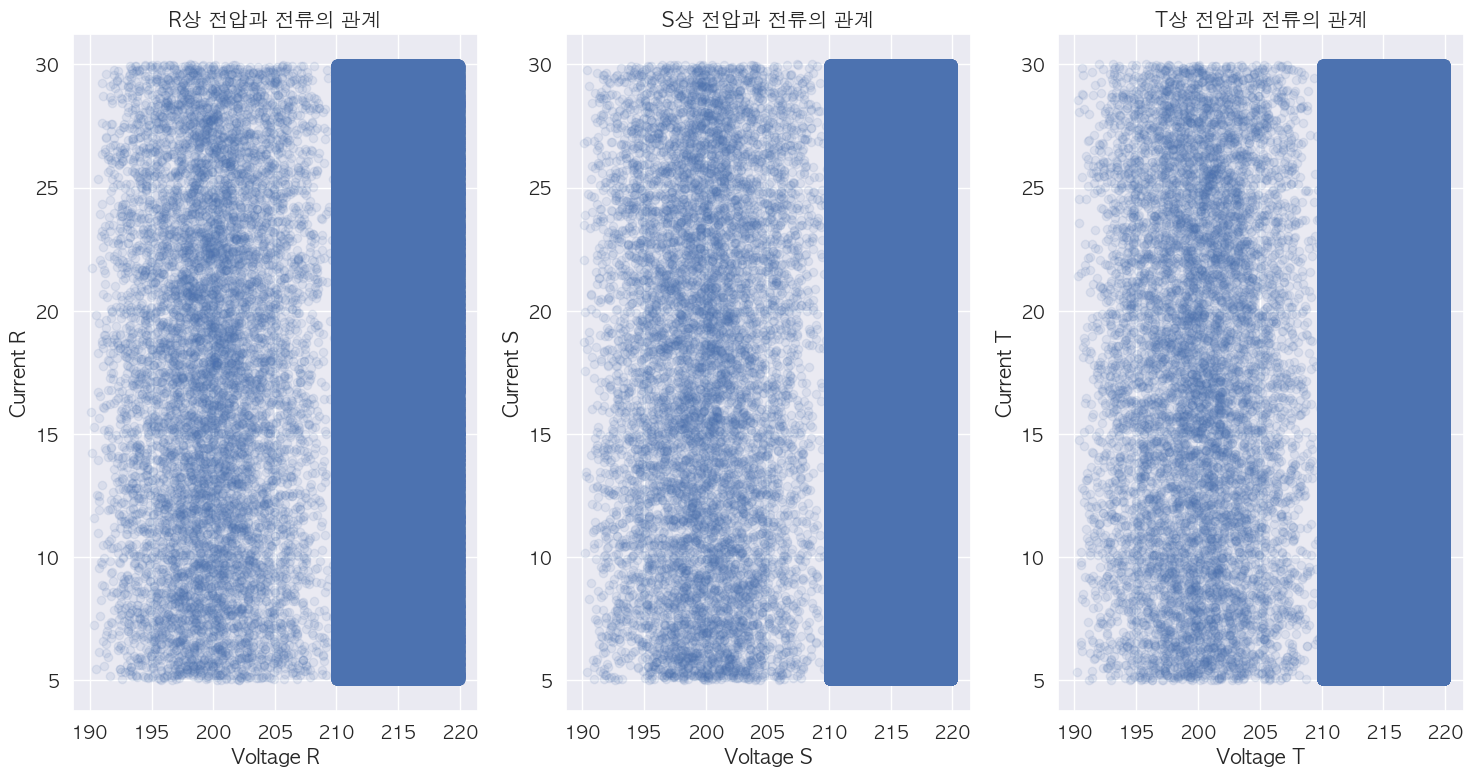

In [23]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.scatter(df["voltageR"], df["currentR"], alpha=0.1)
plt.title("R상 전압과 전류의 관계")
plt.xlabel("Voltage R")
plt.ylabel("Current R")

plt.subplot(1, 3, 2)
plt.scatter(df["voltageS"], df["currentS"], alpha=0.1)
plt.title("S상 전압과 전류의 관계")
plt.xlabel("Voltage S")
plt.ylabel("Current S")

plt.subplot(1, 3, 3)
plt.scatter(df["voltageT"], df["currentT"], alpha=0.1)
plt.title("T상 전압과 전류의 관계")
plt.xlabel("Voltage T")
plt.ylabel("Current T")

plt.tight_layout()
plt.show()

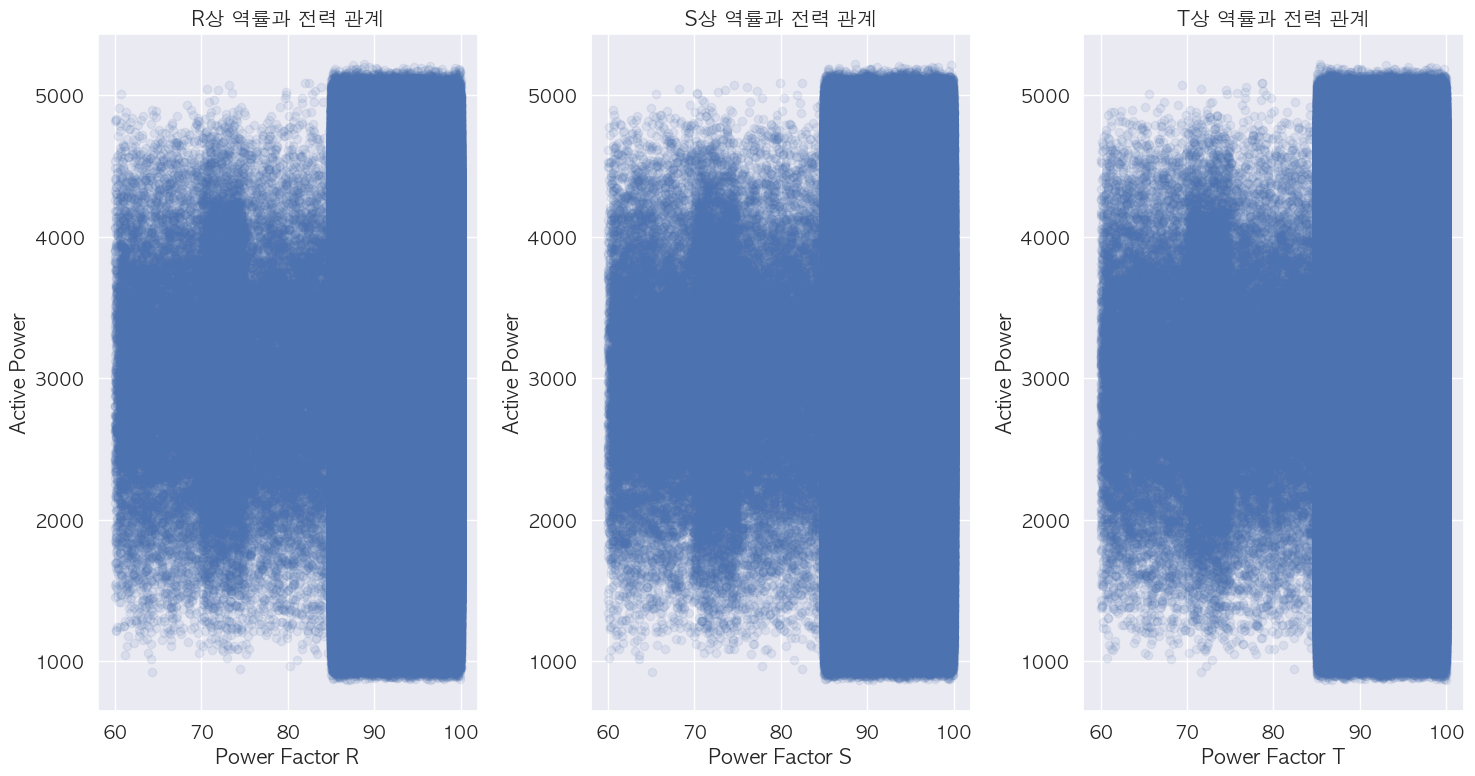

In [24]:
# Power Factor - Active Power check
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.scatter(df["powerFactorR"], df["activePower"], alpha=0.1)
plt.title("R상 역률과 전력 관계")
plt.xlabel("Power Factor R")
plt.ylabel("Active Power")

plt.subplot(1, 3, 2)
plt.scatter(df["powerFactorS"], df["activePower"], alpha=0.1)
plt.title("S상 역률과 전력 관계")
plt.xlabel("Power Factor S")
plt.ylabel("Active Power")


plt.subplot(1, 3, 3)
plt.scatter(df["powerFactorT"], df["activePower"], alpha=0.1)
plt.title("T상 역률과 전력 관계")
plt.xlabel("Power Factor T")
plt.ylabel("Active Power")

plt.tight_layout()
plt.show()

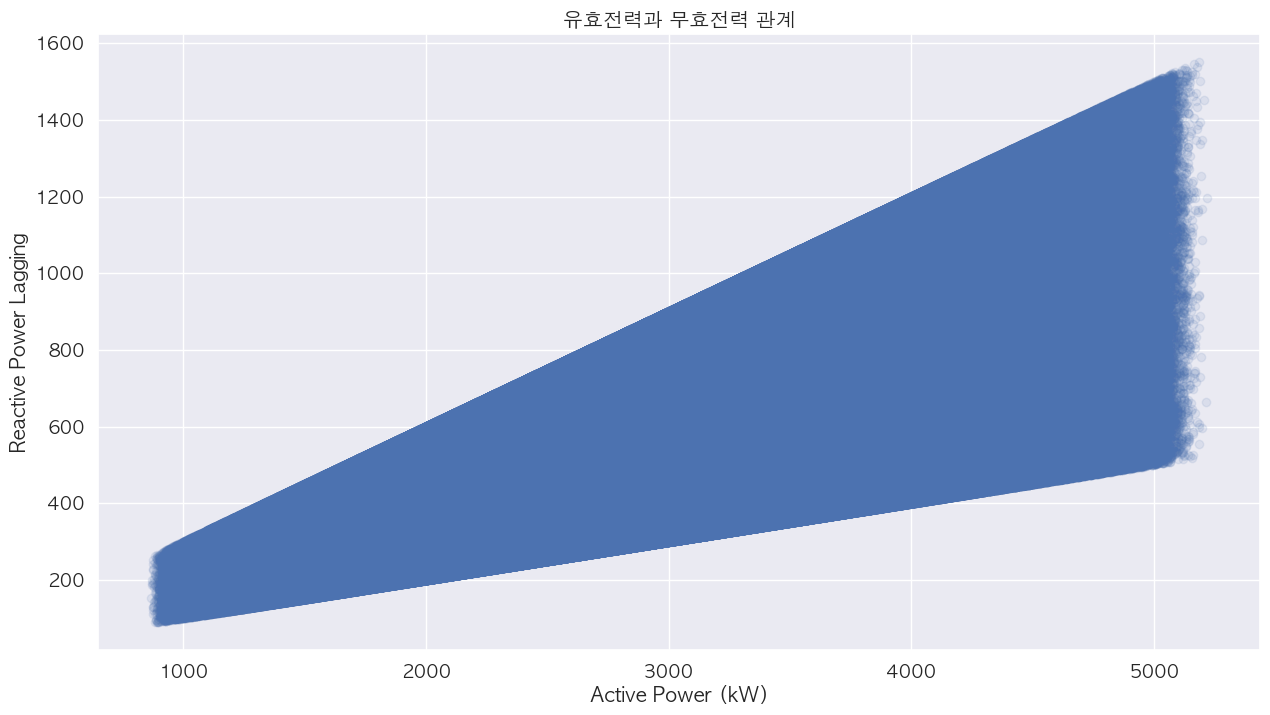

In [25]:
# 유효 전력 - 무효 전력 관계 확인
plt.figure(figsize=(15, 8))
plt.scatter(df["activePower"], df["reactivePowerLagging"], alpha=0.1)
plt.title("유효전력과 무효전력 관계")
plt.xlabel("Active Power (kW)")
plt.ylabel("Reactive Power Lagging")
plt.grid(True)
plt.show()

- 확실히 선형적 관계를 보이는 것을 알 수 있음.

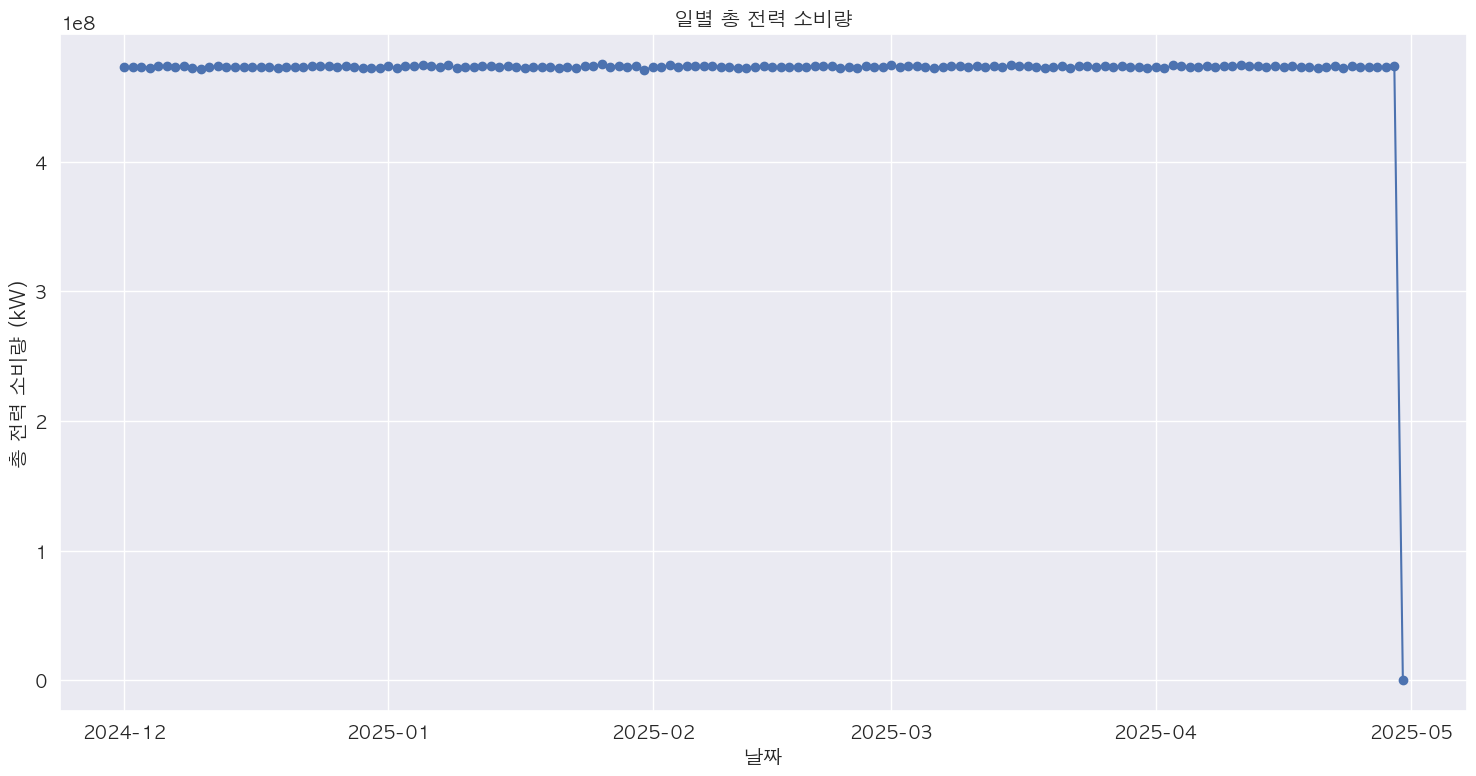

In [26]:
# 일별 전력 소비량 집계
df["date"] = df["datetime"].dt.date
daily_power = df.groupby("date")["activePower"].agg(["mean", "sum", "min", "max"]).reset_index()
daily_power["date"] = pd.to_datetime(daily_power["date"])

# 일별 전력 소비 추세 확인
plt.figure(figsize=(15, 8))
plt.plot(daily_power["date"], daily_power["sum"], marker="o")
plt.title("일별 총 전력 소비량")
plt.xlabel("날짜")
plt.ylabel("총 전력 소비량 (kW)")
plt.grid(True)
plt.tight_layout()
plt.show()

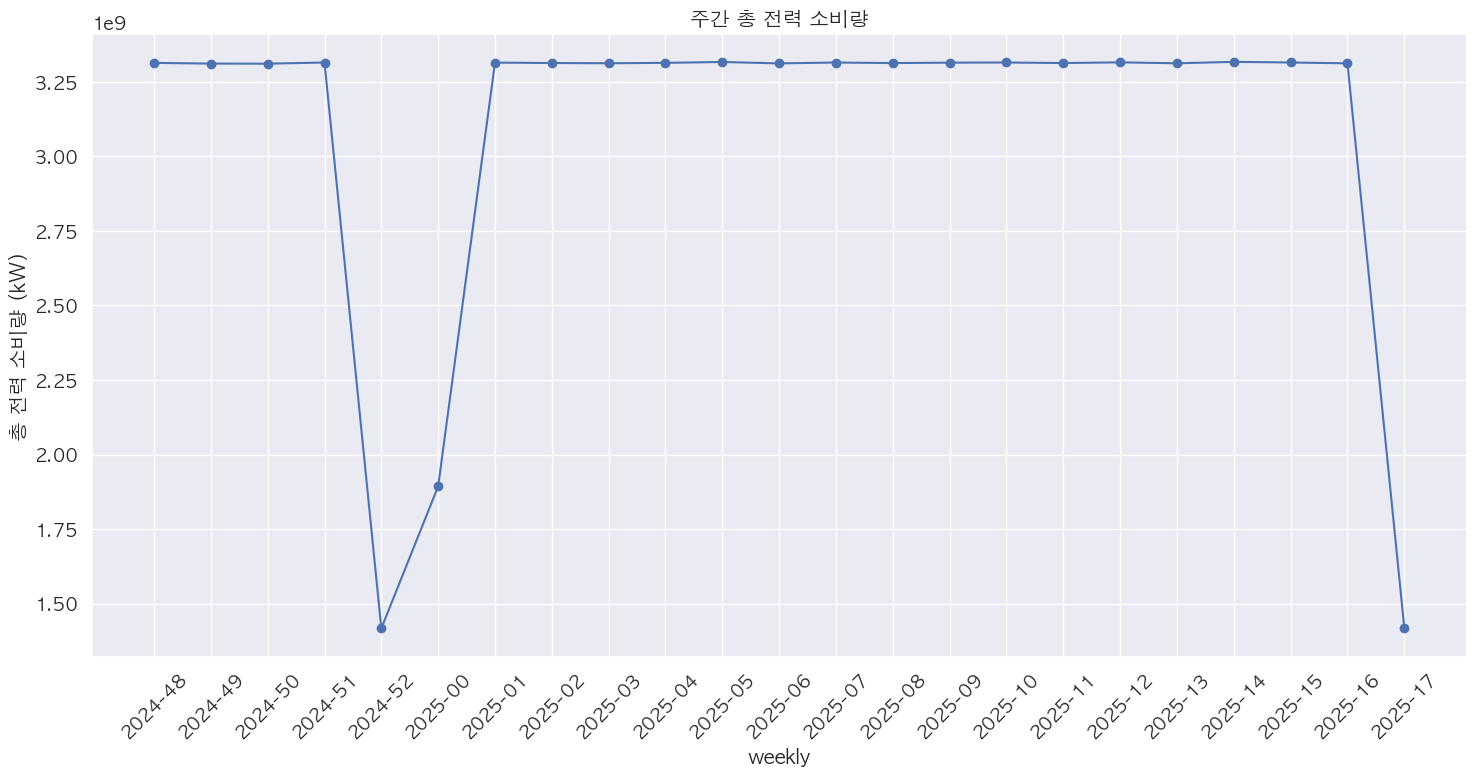

In [28]:
# 주간 전력 소비량 집계
df["week_year"] = df["datetime"].dt.strftime("%Y-%U")
weekly_power = df.groupby("week_year")["activePower"].agg(["mean", "sum", "min", "max"]).reset_index()

plt.figure(figsize=(15, 8))
plt.plot(range(len(weekly_power)), weekly_power["sum"], marker="o")
plt.title("주간 총 전력 소비량")
plt.xlabel("weekly")
plt.xticks(range(len(weekly_power)), weekly_power["week_year"], rotation=45)
plt.ylabel("총 전력 소비량 (kW)")
plt.grid(True)
plt.tight_layout()
plt.show()

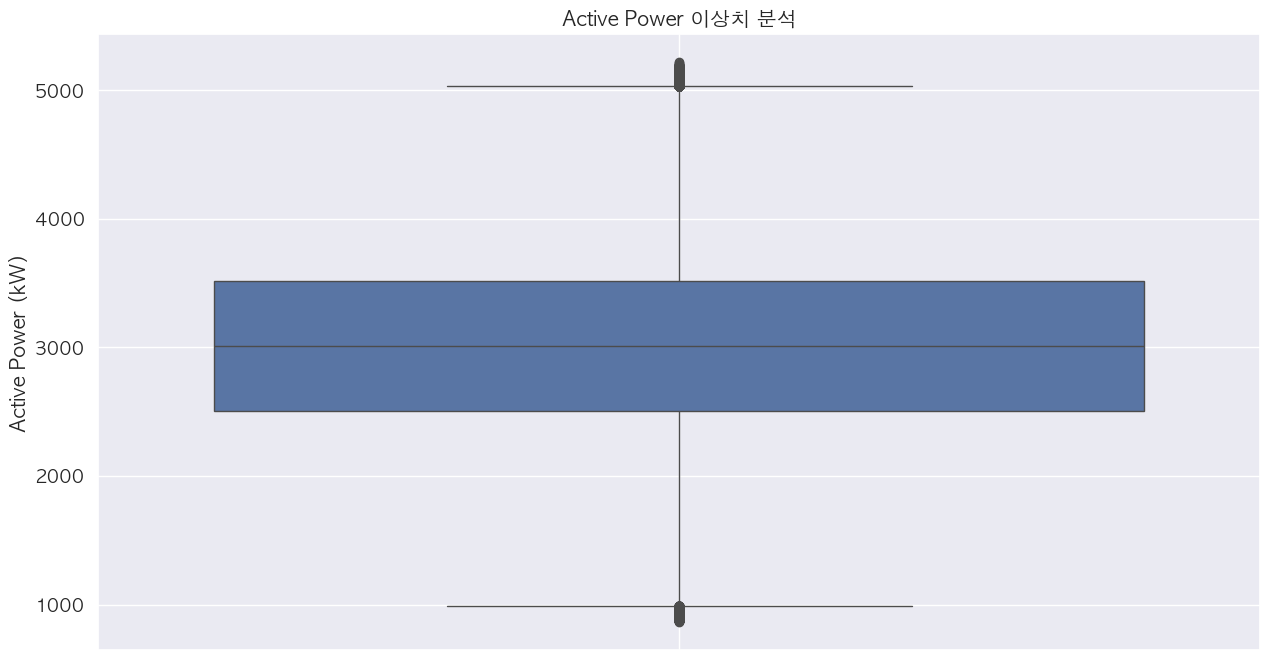

In [29]:
# activePower 이상치 분석
plt.figure(figsize=(15, 8))
sns.boxplot(y="activePower", data=df)
plt.title("Active Power 이상치 분석")
plt.ylabel("Active Power (kW)")
plt.grid(True)
plt.show()

이상치 개수 : 5971, 전체 데이터 대비 비율 : 0.03%


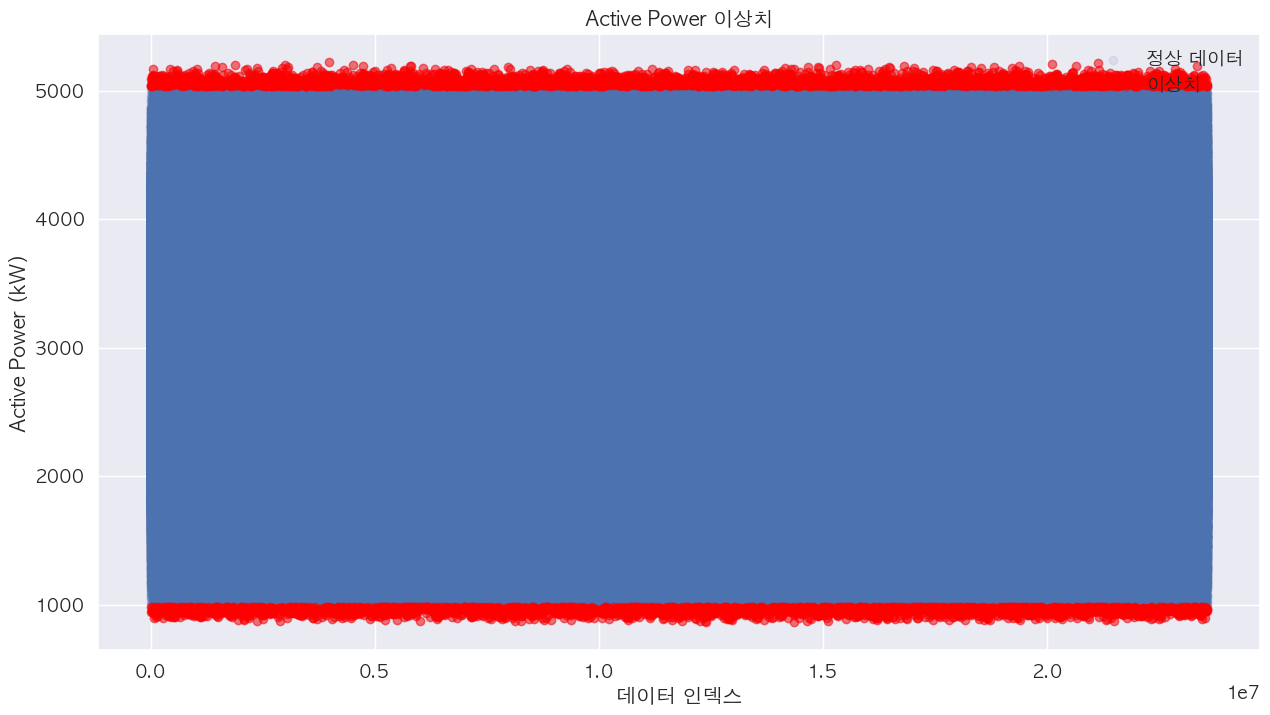

In [30]:
# IQR 방법을 통해 이상치 식별
Q1 = df["activePower"].quantile(0.25)
Q3 = df["activePower"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["activePower"] < lower_bound) | (df["activePower"] > upper_bound)]
print(f"이상치 개수 : {len(outliers)}, 전체 데이터 대비 비율 : {len(outliers)/len(df)*100:.2f}%")

# 시각화
plt.figure(figsize=(15, 8))
plt.scatter(df.index, df["activePower"], alpha=0.1, label="정상 데이터")
plt.scatter(outliers.index, outliers["activePower"], color="red", alpha=0.5, label="이상치")
plt.title("Active Power 이상치")
plt.xlabel("데이터 인덱스")
plt.ylabel("Active Power (kW)")
plt.legend()
plt.grid(True)
plt.show()